**Bibliotecas**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

**Montar o google drive no Colab**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Importar arquivos de configuração do Kaglle**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### ** Download dos dados / descompactando os dados**

In [5]:
!kaggle datasets download phylake1337/fire-dataset

 98% 381M/387M [00:04<00:00, 135MB/s]
100% 387M/387M [00:04<00:00, 91.8MB/s]


In [6]:
!unzip -qq fire-dataset.zip

**Criando o Diretorio Df e unificando os dados dentro dele (não utilizado)**

In [7]:
! mkdir df
!cp -r fire_dataset/fire_images/* df
! cp -r fire_dataset/non_fire_images/* df

**Tentado dividir os dados em treino, validação e teste (sem sucesso)**

### Data Preprocessing

In [8]:
fire_dir = glob.glob('fire_dataset/fire_images/*.png')
non_fire_dir = glob.glob('fire_dataset/non_fire_images/*.png')

In [9]:
fire_df = []
non_fire_df = []
for i in fire_dir:
    fire_df.append([i,'fire'])
for j in non_fire_dir:
    non_fire_df.append([j,'non_fire'])
df = fire_df + non_fire_df
random.shuffle(df)

In [ ]:
!rm -r new_fire/

In [ ]:
data_df = pd.DataFrame(df, columns = ['path','label'])

## **This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.**

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
IMG_SHAPE = 256
BATCH_SIZE = 20

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory="fire_dataset",
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary',
                                               subset='training')

#image_gen_val = ImageDataGenerator(rescale=1./255)

validation_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory="fire_dataset",
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary',
                                                 subset='validation')

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [ ]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(256,256),
                                              class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation')


Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


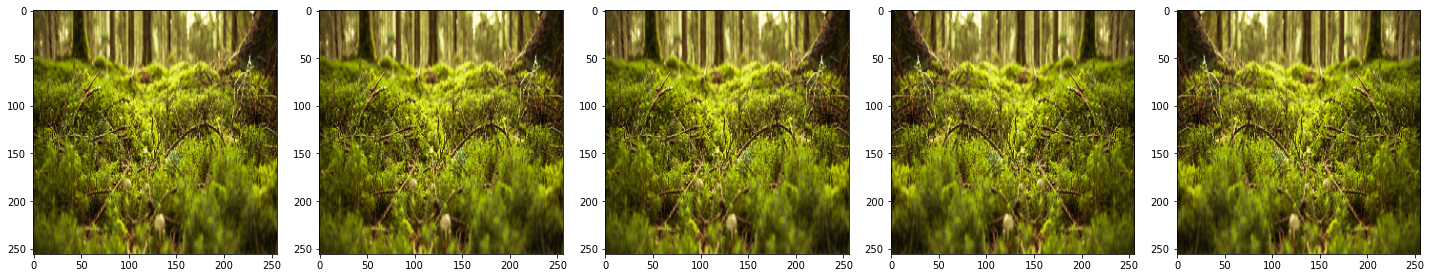

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

**Compilando o Modelo**

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [ ]:
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

In [ ]:
history = model.fit(train_generator,
                               epochs=20,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/20
40/40 [==============================] - 156s 4s/step - loss: 0.4328 - accuracy: 0.3688 - val_loss: 0.5425 - val_accuracy: 0.7588
Epoch 2/20


Process Keras_worker_ForkPoolWorker-20:
Process Keras_worker_ForkPoolWorker-19:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-18:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py", line 563, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  Fil

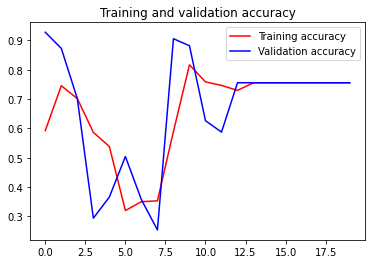

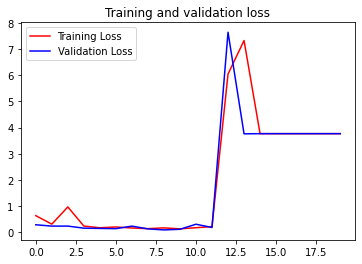

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model = tf.keras.models.load_model("best_model.h5")

val_acc1 = model.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

50/50 [==============================] - 29s 579ms/step - loss: 0.2886 - accuracy: 0.9279
validation_accuracy: 0.9279279112815857


**listar as redes realmente disponíveis em seu Keras**

In [ ]:
import tensorflow.keras.applications as app
print(dir(app))


['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


**O Modelo pre treinado VGG16.**

In [ ]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
#x = datagen(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
modelvgg16 = tf.keras.Model(inputs, outputs)

modelvgg16.compile(optimizer = Adam(learning_rate=0.0001,decay=1e-5), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

callbacksvgg16 = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

In [ ]:
history = modelvgg16.fit_generator(train_generator,
                         epochs=20,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=callbacksvgg16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
30/50 [=================>............] - ETA: 14:09 - loss: 0.2342 - accuracy: 0.7596

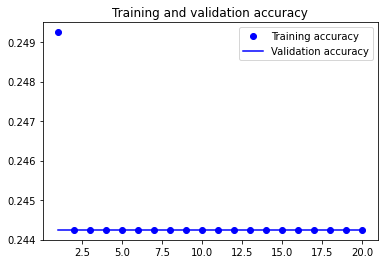

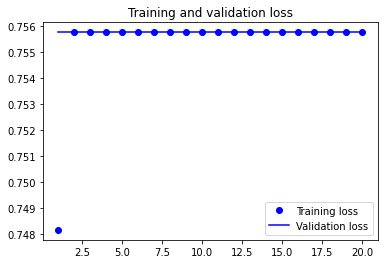

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**### O Modelo pre treinado InceptionV3**

In [ ]:
Inception_V3 = InceptionV3(input_shape=(256,256,3),
                           include_top=False)
Inception_V3.trainable = False

In [ ]:
Inception_V3.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [ ]:
from keras import models
from keras import layers

x = layers.Flatten()(Inception_V3.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model_Inception_V3 = Model(Inception_V3.input, x) 

In [ ]:
model_Inception_V3.compile(optimizer = Adam(learning_rate=0.0001,decay=1e-5), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model_Inception_V3.fit(train_generator,
                               epochs=20,
                               verbose=1,
                               validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.6763 - acc: 0.9019

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1= model_Inception_V3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

**O Modelo pre treinado VGG16 EfficientNet B0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### O Modelo pre treinado EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

**negrito**### Comparando os modelos

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()